# Medical Insurance prediction using linear regression

In this notebook, we will work on the medical insurance dataset and work on the linear regression model using Pytorch.

Source for the dataset is https://www.kaggle.com/mirichoi0218/insurance


https://www.kaggle.com/shubha23/insurance-forecast-a-regression-problem

https://www.kaggle.com/sivakumarai/insurance-premium-prediction-linear-regression

https://www.kaggle.com/prasy46/insurance-premium-prediction-by-linear-regression


https://www.kaggle.com/pvaibhav1995/insurance-forecast-by-using-linear-regression

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Data Exploration

Let's load the data from the csv file using Panda's read_csv function. This will load the data as dataframe.

In [2]:
df = pd.read_csv("./input/insurance.csv")

In [3]:
# First five rows 
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
# Last five rows
df.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [5]:
# Statistical information for our dataset
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


What can we infer from descriptive stats?

Average age of customers is about 39 years with maximum age of 64 years and they have one child on an average with minimum of no child and maximum of 5 children. 75% of observations show 51 years of age and 2 children. The charges for insurance on an average is 13270.42 units with 75% obseravtions close to 16639.91 units.

In [6]:
# Data types for all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# See if there are any missing values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


## Data Visualization

Let's visualize the target variable - 'expenses' first and see its distribution using histogram. 

Text(0.5, 1.0, 'Distribution of expenses')

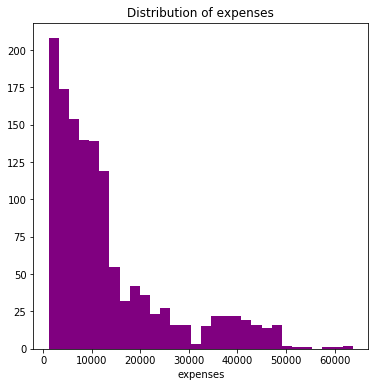

In [8]:
plt.figure(figsize=(6,6))
plt.hist(df.expenses, bins = 'auto', color = 'purple')
plt.xlabel("expenses")
plt.title("Distribution of expenses")

What can we infer from data distribution?

- Most of the expenses are between 100 and 10000
- Very few people are charged above 50000
- Mean is 13270 (from descriptive stats) and the data is towards the left of distribution


Let's now plot the outliers - expenses vs other variables

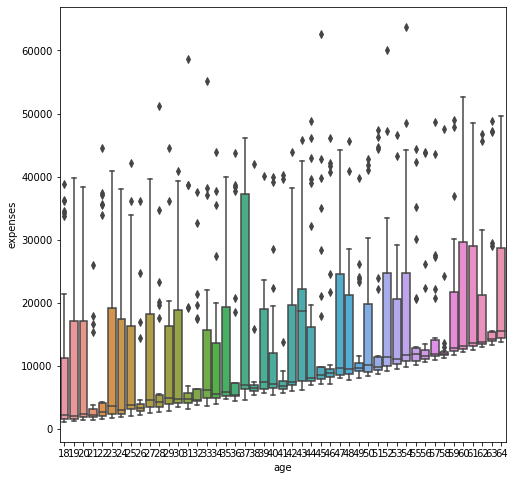

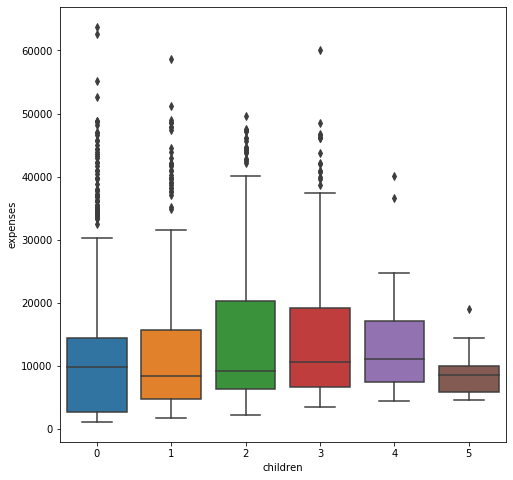

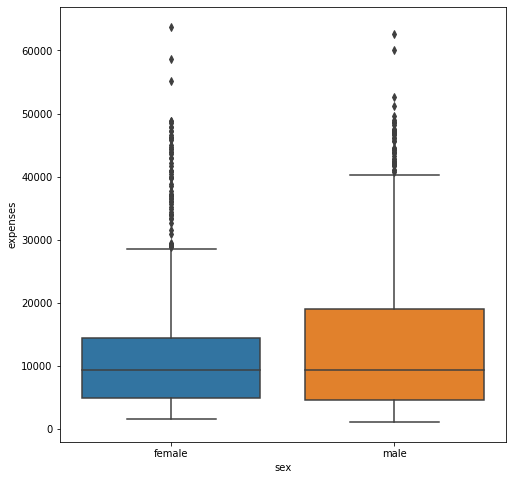

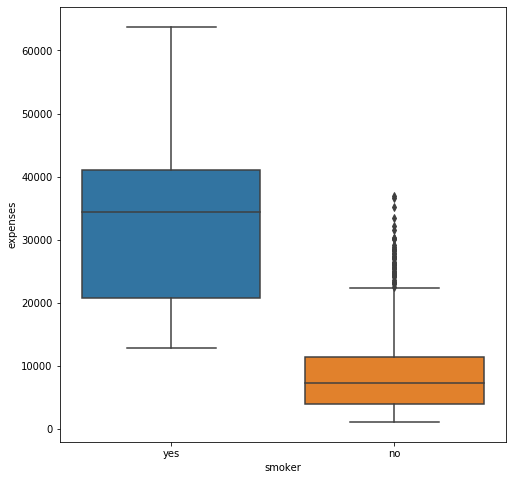

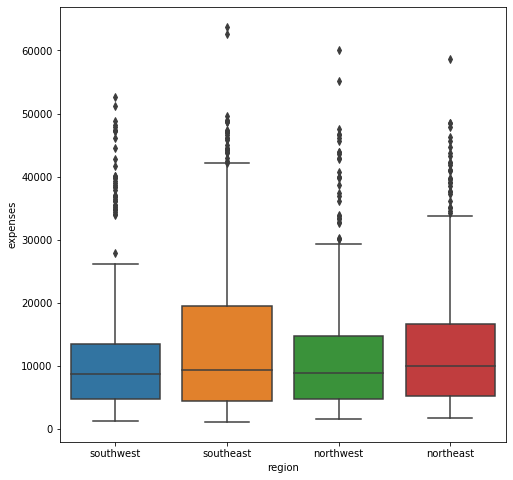

In [9]:
cols = ['age', 'children', 'sex', 'smoker', 'region']
for col in cols:
    plt.figure(figsize=(8,8))
    sns.boxplot(x = df[col], y = df['expenses'])

What can we infer from box-plots?

- As age increases, the insurance cost increases i.e. younger people have less cost
- Customers with 2 children are charged more
- Being male or female has no impact but males have high cost range
- Smokers are charged higher
- Region does not show much correlation with charges, though, South-east region have larger range up to about 20,000 in its dsitribution of customer charges.



In our dataset, we have three qualitative variables i.e. sex, smoker and region. We can convert these to quantitative variables for a better model. Categorical varaibles can simply be assigned a binary value since they have only two values. Region can be converted using Panda's get_dummies method.

In [10]:
df.region = pd.get_dummies(df.region)
df.region

0       0
1       0
2       0
3       0
4       0
       ..
1333    0
1334    1
1335    0
1336    0
1337    0
Name: region, Length: 1338, dtype: uint8

In [11]:
df.smoker

0       yes
1        no
2        no
3        no
4        no
       ... 
1333     no
1334     no
1335     no
1336     no
1337    yes
Name: smoker, Length: 1338, dtype: object

In [12]:
df.smoker
df.smoker = [1 if x == 'yes' else 0 for x in df.smoker]
df.sex = [1 if x == 'male' else 0 for x in df.sex]
df.smoker

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64

In [13]:
df.expenses = pd.to_numeric(df.expenses)

In [14]:
# Create Correlation matrix for all features of data.
df.corr()

,age,sex,bmi,children,smoker,region,expenses
age,1.000000,-0.020856,0.109341,0.042469,-0.025019,0.002475,0.299008
sex,-0.020856,1.000000,0.046380,0.017163,0.076185,-0.002425,0.057292
bmi,0.109341,0.046380,1.000000,0.012645,0.003968,-0.138091,0.198576
children,0.042469,0.017163,0.012645,1.000000,0.007673,-0.022808,0.067998
smoker,-0.025019,0.076185,0.003968,0.007673,1.000000,0.002811,0.787251
region,0.002475,-0.002425,-0.138091,-0.022808,0.002811,1.000000,0.006349
expenses,0.299008,0.057292,0.198576,0.067998,0.787251,0.006349,1.000000


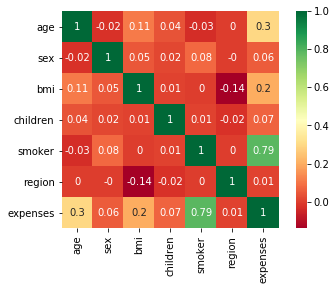

In [15]:
# Generate heatmap to visualize strong & weak correlations.
sns.heatmap(df.corr().round(2), square=True, cmap='RdYlGn', annot=True)

From the heatmap, we can infer that the expenses & smoker have the highest co-relation and expenses & region have the lowest co-relation.

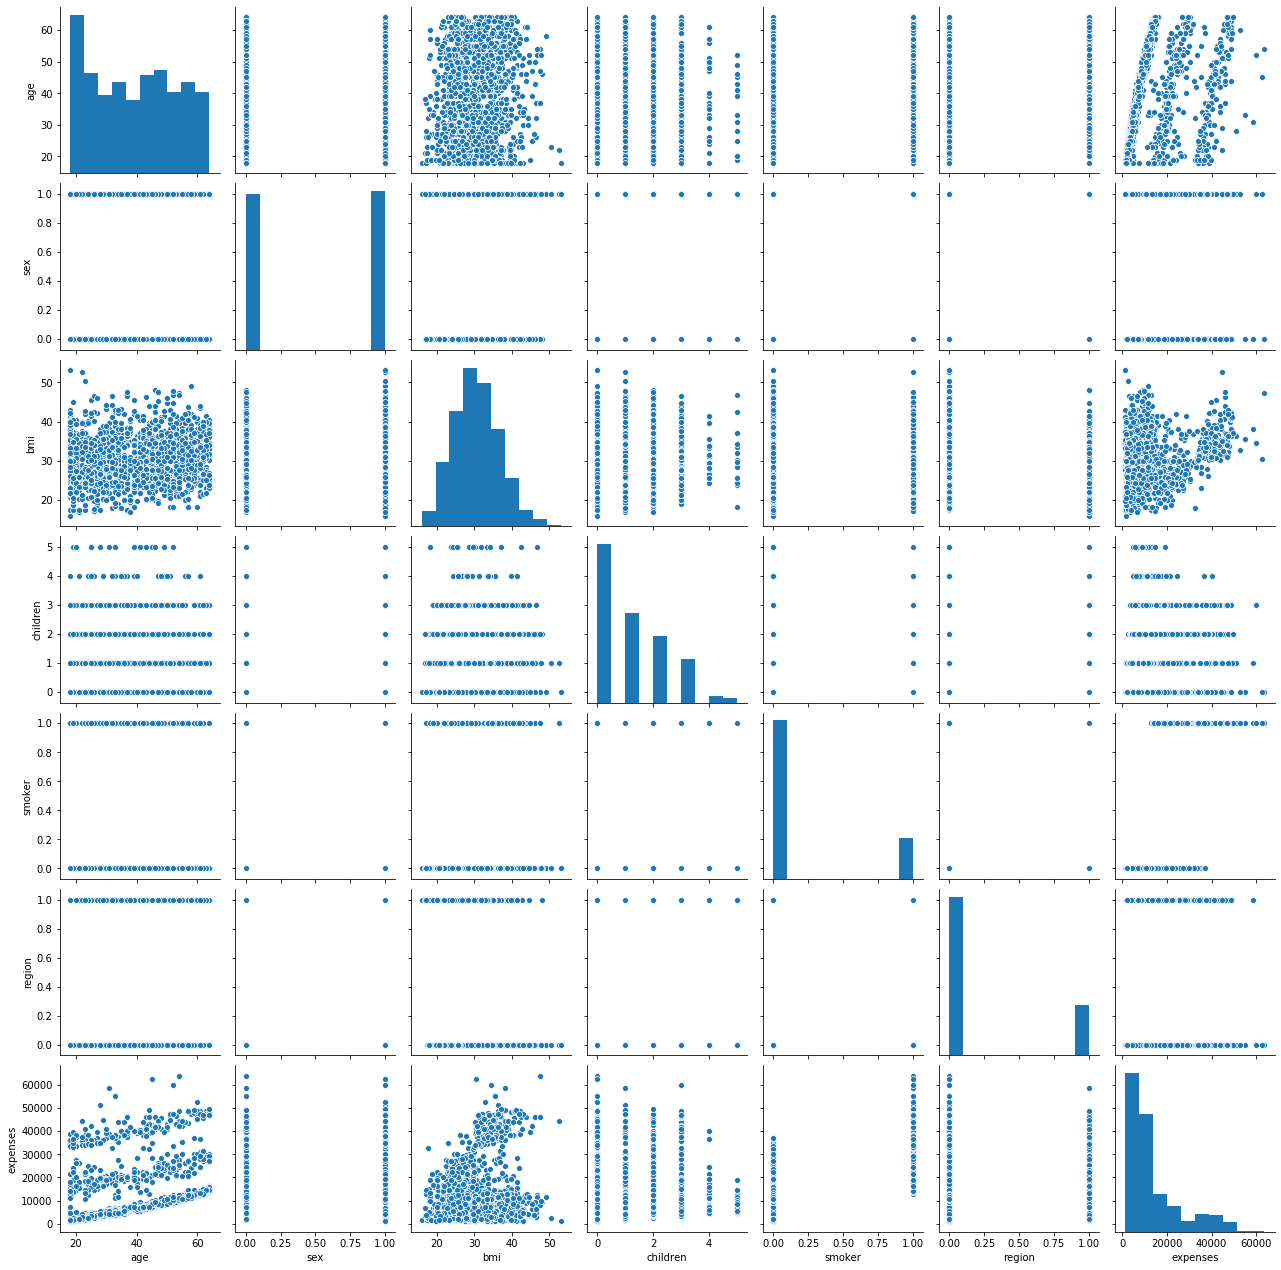

In [62]:
sns.pairplot(df)

In [63]:
targets_df = df.expenses
inputs_df = df.drop(['expenses'], axis=1)

inputs_df

,age,sex,bmi,children,smoker,region
0,19,0,27.9,0,1,0
1,18,1,33.8,1,0,0
2,28,1,33.0,3,0,0
3,33,1,22.7,0,0,0
4,32,1,28.9,0,0,0
...,...,...,...,...,...,...
1333,50,1,31.0,3,0,0
1334,18,0,31.9,0,0,1
1335,18,0,36.9,0,0,0
1336,21,0,25.8,0,0,0


In [64]:
# Convert Dataframe to Numpy Arrays
inputs_narray = inputs_df.to_numpy('float32')
target_narray = targets_df.to_numpy('float32')

In [65]:
# Create Pytorch Tensors from Numpy Array's

inputs = torch.from_numpy(inputs_narray)
targets = torch.from_numpy(target_narray)

In [68]:
inputs.dtype

torch.float32

## Step 2: Prepare the dataset for training


In [69]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [89]:
num_rows = inputs.shape[0]

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [90]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [91]:
val_percent = 0.10 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size , val_size ])

Finally, we can create data loaders for training & validation.

In [92]:
batch_size = 64

In [93]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [94]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[18.0000,  0.0000, 32.1000,  2.0000,  0.0000,  0.0000],
        [47.0000,  1.0000, 29.8000,  3.0000,  0.0000,  0.0000],
        [52.0000,  1.0000, 27.4000,  0.0000,  1.0000,  0.0000],
        [48.0000,  1.0000, 29.6000,  0.0000,  0.0000,  0.0000],
        [37.0000,  1.0000, 30.8000,  0.0000,  0.0000,  0.0000],
        [51.0000,  0.0000, 35.0000,  2.0000,  1.0000,  1.0000],
        [19.0000,  0.0000, 17.8000,  0.0000,  0.0000,  0.0000],
        [35.0000,  1.0000, 27.1000,  1.0000,  0.0000,  0.0000],
        [40.0000,  1.0000, 32.8000,  1.0000,  1.0000,  1.0000],
        [19.0000,  0.0000, 28.9000,  0.0000,  0.0000,  0.0000],
        [36.0000,  1.0000, 35.2000,  1.0000,  1.0000,  0.0000],
        [22.0000,  0.0000, 39.8000,  0.0000,  0.0000,  1.0000],
        [57.0000,  0.0000, 29.8000,  0.0000,  1.0000,  0.0000],
        [29.0000,  0.0000, 27.9000,  1.0000,  1.0000,  0.0000],
        [18.0000,  0.0000, 30.1000,  0.0000,  0.0000,  1.0000],
        [42.0000,  1.0000, 37.20

## Step 3: Create a Linear Regression Model


Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [95]:
input_size = len(inputs_df.columns)
output_size = 1

In [96]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out,targets) 
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [97]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [98]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1707,  0.2400, -0.0108, -0.0098,  0.3481,  0.1212]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3026], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [100]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

Use the `evaluate` function to calculate the loss on the validation set before training.**

In [101]:
result = evaluate(model, val_ds)
print(result)

{'val_loss': 11789.875}


/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [102]:
epochs = 100
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Users/sa

Epoch [20], val_loss: 14715.1221
Epoch [40], val_loss: 14714.1562
Epoch [60], val_loss: 14713.1768
Epoch [80], val_loss: 14712.1982
Epoch [100], val_loss: 14711.2266


In [103]:
epochs = 100
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Users/sa

Epoch [20], val_loss: 14701.5000
Epoch [40], val_loss: 14691.7607
Epoch [60], val_loss: 14682.0469
Epoch [80], val_loss: 14672.3018
Epoch [100], val_loss: 14662.5732


In [104]:
epochs = 100
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Users/sa

Epoch [20], val_loss: 14565.2578
Epoch [40], val_loss: 14467.9404
Epoch [60], val_loss: 14370.6123
Epoch [80], val_loss: 14273.2822
Epoch [100], val_loss: 14175.9639


In [105]:
epochs = 100
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Users/sa

Epoch [20], val_loss: 13224.3955
Epoch [40], val_loss: 12438.8311
Epoch [60], val_loss: 11806.9014
Epoch [80], val_loss: 11286.7607
Epoch [100], val_loss: 10855.7646


In [106]:
epochs = 100
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/Users/sarbjit/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Users/sa

Epoch [20], val_loss: 9249.7070
Epoch [40], val_loss: 8982.9990
Epoch [60], val_loss: 8934.1240
Epoch [80], val_loss: 8917.0078
Epoch [100], val_loss: 8909.7666


Text(0, 0.5, 'Loss')

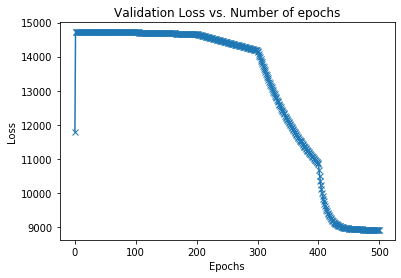

In [107]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5
val_loss_list = [vloss['val_loss'] for vloss in val_loss]
plt.plot(val_loss_list, '-x')
plt.title('Validation Loss vs. Number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Step 5: Make predictions using the trained model

In [109]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [110]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([59.0000,  1.0000, 26.4000,  0.0000,  0.0000,  0.0000])
Target: tensor(11743.2998)
Prediction: tensor([10942.4648])


In [111]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([39.0000,  0.0000, 22.8000,  3.0000,  0.0000,  1.0000])
Target: tensor(7985.8198)
Prediction: tensor([7929.2964])


In [112]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([30.,  0., 20.,  3.,  0.,  0.])
Target: tensor(5693.4302)
Prediction: tensor([6416.1772])
